# Pipeline de análise de imagens de RX normal, pneumonia ou COVID19 visando emissão de laudos / diagnóstico automatizados a serem confirmados pelo profissional de medicina

### Rede Neural VGG16

In [ ]:
import glob
import shutil
import cv2
import os
from PIL import Image
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import *
from keras.applications.vgg16 import VGG16
from keras import layers
# from skimage.feature import local_binary_pattern

import warnings
# Ignorar warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
name_list = glob.glob('/content/drive/MyDrive/PP2/Covid19-Pneumonia-Normal-Chest-X-Ray-Images-Dataset/NORMAL/*')

labels = ['NORMAL', 'COVID', 'PNEUMONIA']

# Carregando as imagens de treinamento e seus rótulos
X= []
y = []

for name in name_list:
  y.append(0)
  img = cv2.imread(name)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = cv2.resize(img,(100,100))
  X.append((img))
len(X)

1802

In [ ]:
name_list = glob.glob('/content/drive/MyDrive/PP2/Covid19-Pneumonia-Normal-Chest-X-Ray-Images-Dataset/COVID/*')

for name in name_list:
  y.append(1)
  img = cv2.imread(name)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = cv2.resize(img,(100,100))
  X.append((img))
len(X)

3428

In [ ]:
name_list = glob.glob('/content/drive/MyDrive/PP2/Covid19-Pneumonia-Normal-Chest-X-Ray-Images-Dataset/PNEUMONIA/*')

for name in name_list:
  y.append(2)
  img = cv2.imread(name)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = cv2.resize(img,(100,100))
  X.append((img))
len(X)

5233

In [ ]:
X = np.array(X)
y = np.array(y).reshape(-1,1)

In [ ]:
print(len(X))
print(X.shape)
print(y.shape)

5233
(5233, 100, 100, 3)
(5233, 1)


In [ ]:
from sklearn.model_selection import train_test_split
# Divide o conjunto de dados em 80% de conjunto de treinamento e 20% de conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Divida o conjunto de dados de teste em 50% do conjunto de validação e 50% do conjunto de teste
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42)

# Imprime informações sobre o tamanho dos conjuntos de dados
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(4186, 100, 100, 3)
(210, 100, 100, 3)
(837, 100, 100, 3)


In [ ]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100,100, 3))

# Congela os pisos do modelo VGG16
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dense(1))
model.add(Activation("sigmoid"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              4719616   
                                                                 
 activation_3 (Activation)   (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 activation_4 (Activation)   (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [ ]:
%%time
learning_rate = 0.0001 # Taxa de aprendizado inicial
decay_steps = 10       # Número de épocas para aplicar o decaimento
decay_rate = 1         # Taxa de redução da taxa de aprendizado

# Inicializa o escalonador de taxa de aprendizado
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate, decay_steps, decay_rate)
optimizer1 = tf.keras.optimizers.Adam(learning_rate = lr_scheduler)
model.compile(optimizer = optimizer1, loss = tf.keras.losses.CategoricalCrossentropy(),metrics =['accuracy'])

history = model.fit(X_train, y_train, batch_size = 32, epochs = 5, validation_data = (X_val, y_val))

Epoch 1/5
131/131 [==============================] - 18s 51ms/step - loss: 0.0000e+00 - accuracy: 0.5645 - val_loss: 0.0000e+00 - val_accuracy: 0.5810
Epoch 2/5
131/131 [==============================] - 5s 36ms/step - loss: 0.0000e+00 - accuracy: 0.6025 - val_loss: 0.0000e+00 - val_accuracy: 0.6048
Epoch 3/5
131/131 [==============================] - 5s 35ms/step - loss: 0.0000e+00 - accuracy: 0.6073 - val_loss: 0.0000e+00 - val_accuracy: 0.5952
Epoch 4/5
131/131 [==============================] - 5s 35ms/step - loss: 0.0000e+00 - accuracy: 0.6094 - val_loss: 0.0000e+00 - val_accuracy: 0.6048
Epoch 5/5
131/131 [==============================] - 5s 37ms/step - loss: 0.0000e+00 - accuracy: 0.6082 - val_loss: 0.0000e+00 - val_accuracy: 0.6048
CPU times: user 13.6 s, sys: 2.22 s, total: 15.8 s
Wall time: 42.8 s


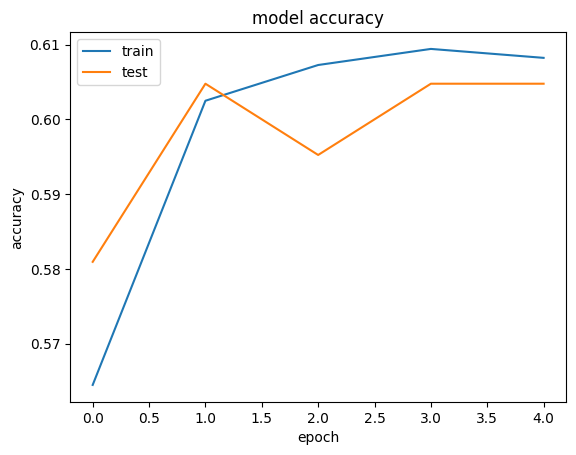

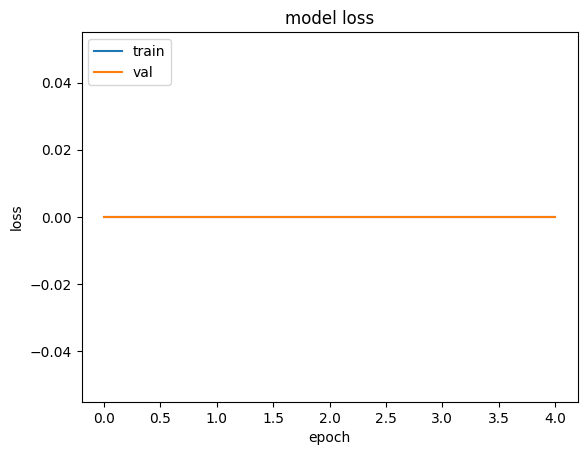

In [ ]:
from matplotlib import pyplot  as plt

# Resumo das acurácias
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc ='upper left')
plt.show()

# Resumo das perdas
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc ='upper left')
plt.show()

In [ ]:
model.save('model1.h5')

In [ ]:
model1 = load_model('model1.h5')

In [ ]:

y_hat = model1.predict(X_test)
def predict(y_hat):
    y_hat[y_hat >= 0.5] =1
    y_hat[y_hat<0.5] =0
    return y_hat
y_pred = predict(y_hat)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

27/27 [==============================] - 1s 46ms/step
0.6021505376344086


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
labels = ['Covid', 'Normal', 'Pneumonia']
report = classification_report(y_test, y_pred, target_names=labels)
print(report)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

              precision    recall  f1-score   support

       Covid       0.84      0.96      0.89       295
      Normal       0.44      0.90      0.59       247
   Pneumonia       0.00      0.00      0.00       295

    accuracy                           0.60       837
   macro avg       0.43      0.62      0.50       837
weighted avg       0.43      0.60      0.49       837

Accuracy: 0.6021505376344086


[[282  13   0]
 [ 25 222   0]
 [ 29 266   0]]


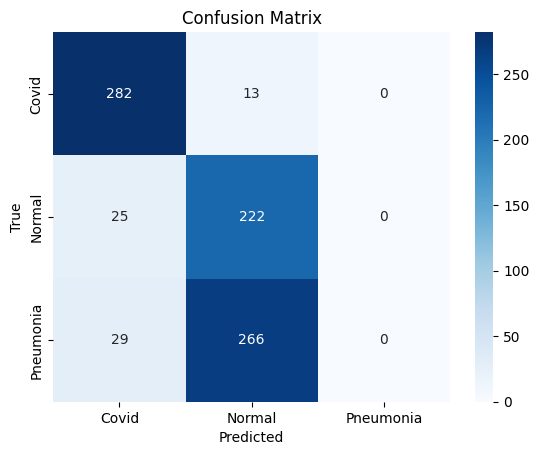

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Configuração do eixo x e eixo y
tick_labels = ['Covid', 'Normal', 'Pneumonia']
plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

# Nomeia os eixos
plt.xlabel('Predicted')
plt.ylabel('True')

# Mostra o gráfico
plt.title('Confusion Matrix')
plt.show()